In [1]:
#MOUNT DRIVE
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
#import libraries
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
#Logistic Regression as a Neural Network

class LogisticRegression:
  
  def __init__(self,  n_features, n_examples):
    self.n_features = n_features
    self.n_examples = n_examples
    self.w = np.random.randn(self.n_features, 1)
    self.b = np.random.randn(1,1)
  
  # reset - randomly initilize weights to start training3
  def reset(self,  n_features, n_examples):
    self.n_features = n_features
    self.n_examples = n_examples
    self.w = np.random.randn(self.n_features, 1)
    self.b = np.random.randn(1,1)
    
  def forward(self, X, y):
    n_features = X.shape[0]
    n_examples = X.shape[1]
    self.X = X
    #assert(X.shape == (self.n_features, self.n_examples))
    self.z = np.dot(self.w.T, X) + self.b
    self.y_hat = 1 / (1 + np.exp(-self.z))
    self.y = y
    # You dont have to compute the loss for backward pass.
    self.loss = 0
    for idx in range(n_examples):
      if self.y[0, idx] == 1:
        self.loss += -np.log(self.y_hat[0, idx])
      else:
        self.loss += -np.log(1 - self.y_hat[0, idx])
    self.loss = self.loss / n_examples
    return self.y_hat, self.loss
  
  def backward(self):
    """
    Returns gradient wrt to w and b (dw and db)
    """
    dz = self.y_hat - self.y
    dw = (1.0 / self.n_examples) * np.dot(self.X, dz.T)
    db = (1.0 / self.n_examples) * np.sum(dz)
    db = db.reshape((1,1))
    return dw, db

  #Training function - fits model to the data. Trains with the given hyperparameters

  def fit(self, X, y, N_EPOCHS, lr, beta, n_iter_lr_decay, lr_decay):
    n_features = X.shape[0]
    n_examples = X.shape[1]

    #logistic_regression = LogisticRegression(n_features, n_examples)


    for idx, epoch in enumerate(range(N_EPOCHS)):

      y_hat, loss = self.forward(X, y)
      if(idx % 50 == 0):
        print("epoch : " + str(epoch) + " ------- Loss : " + str(loss))

      dw, db = self.backward()

      #Learning rate decay
      if(idx % n_iter_lr_decay == 0):
        lr = lr * lr_decay

      #Update with weight decay (Weight Decay == l2 regularizarion)
      self.w -= (lr * dw + beta * self.w)
      self.b -= (lr * db + beta * self.b)

    return self.w, self.b
  
  def infer(self, X, y, threshold):
    y_hat, loss = self.forward(X, y)
    y_hat_class = []
    tp = 0
    tn = 0
    fp = 0
    fn = 0
    n_examples = y.shape[1]
    for i in range(n_examples):
      if y_hat[0,i] <= threshold:
        y_hat_class.append(0)
        if y[0, i] == 0:
          tn += 1
        else:
          fn += 1
      else:
        y_hat_class.append(1)
        if y[0, i] == 0:
          fp += 1
        else:
          tp += 1
    
    y_hat_class = np.array(y_hat_class)
    y_hat_class = y_hat_class.reshape((1, n_examples))
    
    confusion_dict = {}
    
    confusion_dict['tp'] = tp / n_examples
    confusion_dict['fn'] = fn / n_examples
    confusion_dict['tn'] = tn / n_examples
    confusion_dict['fp'] = fp / n_examples
    
    accuracy = (tp + tn) / n_examples
    
    return y_hat, y_hat_class, loss, accuracy, confusion_dict

In [0]:
#Choose hyperparameters using cross validation

from sklearn.model_selection import StratifiedShuffleSplit

#Choose beta using cross validation

#hyper_params = (N_EPOCHS, lr, beta, n_iter_lr_decay, lr_decay)
def cross_validate(model, X, y, hyper_params, beta_list):
  (n_folds, N_EPOCHS, lr, beta, n_iter_lr_decay, lr_decay) = hyper_params
  acc_all_param = []
  loss_all_param = []
  threshold = 0.5
  # TODO: Folds are not disjoint 
  sss = StratifiedShuffleSplit(n_splits=n_folds, test_size=0.25, random_state=0)
  for i, hp in enumerate(beta_list):
    print("beta index : ", i)
    acc_per_param = []
    loss_per_param = []
    X_t, y_t = X.T, y.T
    fold = 0
    for train_index, test_index in sss.split(X_t, y_t):
      print("fold : ", fold)
      fold += 1
      X_train, X_test = X_t[train_index], X_t[test_index]
      y_train, y_test = y_t[train_index], y_t[test_index]
      
      X_train = X_train.T
      X_test = X_test.T
      y_train = y_train.T
      y_test = y_test.T
      
      model.fit(X_train, y_train, N_EPOCHS, lr, hp, n_iter_lr_decay, lr_decay)
      
      y_hat, y_hat_class, loss, accuracy, confusion_dict = \
      model.infer(X_test, y_test, threshold)
      
      acc_per_param.append(accuracy)
      loss_per_param.append(loss)
      
    acc_all_param.append(acc_per_param)
    loss_all_param.append(loss_per_param)
  
  ave_accs = []
  for acc in acc_all_param:
    ave_accs.append(sum(acc) / len(acc))
    
  plt.figure(figsize=(12,6))
  plt.plot(np.log10(beta_list), ave_accs)
  plt.title("Plot of cross validation accuracies and regularization factor values (log of reg factors)")
  plt.xlabel("log reg factors")
  plt.ylabel("Accuracies")
  plt.show()
  print("Cross Validation Results")
  print("Hyper Param values : ")
  print(beta_list)  
  print("Cross Validation Accuracies : ")
  print(ave_accs)
  
  opt_hp = beta_list[ave_accs.index(max(ave_accs))]
  print("optimal beta : ", opt_hp)
  
  return opt_hp


In [5]:
#Data - Prepare Data
# Authentic Bank note dataset
# http://archive.ics.uci.edu/ml/datasets/banknote+authentication#

data_file = "/content/drive/My Drive/coursera/deeplearning/\
01_NeuralNetworksandDeepLearning/datasets/data_banknote_authentication.txt"

X_list = []
y_list = []

f = open(data_file, "r")

for id,line in enumerate(f):
  if line[0] == '#':
    continue
  else:
    example = line.split(",")
    if example[-1][:-1] == '\n':
      example[-1] = example[-1][:-1]
    #print(example)
    example = [float(x) for x in example]
    X_list.append(example[:-1])
    y_list.append(int(example[-1]))
#     if id == 6:
#       break
      
X = np.array(X_list)
y = np.array(y_list)
X = X.T
y = y.reshape((1,y.shape[0]))

print("shape x : ", X.shape, "shape y : ", y.shape)
# print(X,y)

#Send X.T to the shuffling function, and y should be (m,1)
def shuffle_in_unison(a, b):
    shuffled_a = np.empty(a.shape, dtype=a.dtype)
    shuffled_b = np.empty(b.shape, dtype=b.dtype)
    permutation = np.random.permutation(a.shape[0])
#     print("permutation: ", permutation)
    for old_index, new_index in enumerate(permutation):
#       print(old_index, new_index)
      shuffled_a[new_index] = a[old_index]
      shuffled_b[new_index] = b[old_index]
#     print(a)
#     print("shuffled")
#     print(shuffled_a)
    return shuffled_a.T, shuffled_b.T
  
X, y =   shuffle_in_unison(X.T, y.T)
print("After shuffling")
print("shape x : ", X.shape, "shape y : ", y.shape)    

# print(X, y)

shape x :  (4, 1372) shape y :  (1, 1372)
After shuffling
shape x :  (4, 1372) shape y :  (1, 1372)


-----------Cross Validation-----------
beta index :  0
fold :  0
epoch : 0 ------- Loss : 3.8725634843279337
epoch : 50 ------- Loss : 0.4471930358689712
epoch : 100 ------- Loss : 0.3242890881688688
epoch : 150 ------- Loss : 0.30662133269949343
fold :  1
epoch : 0 ------- Loss : 0.308221754039702
epoch : 50 ------- Loss : 0.29259743229757507
epoch : 100 ------- Loss : 0.28985712822306464
epoch : 150 ------- Loss : 0.2912708998701958
fold :  2
epoch : 0 ------- Loss : 0.29531745064295883
epoch : 50 ------- Loss : 0.2837229634311754
epoch : 100 ------- Loss : 0.2831736801416116
epoch : 150 ------- Loss : 0.285953718841951
fold :  3
epoch : 0 ------- Loss : 0.29417498108900597
epoch : 50 ------- Loss : 0.2857981847947513
epoch : 100 ------- Loss : 0.2864991177744911
epoch : 150 ------- Loss : 0.2897042764460233
beta index :  1
fold :  0
epoch : 0 ------- Loss : 0.2945495865803828
epoch : 50 ------- Loss : 0.22855424358951112
epoch : 100 ------- Loss : 0.1994600125434513
epoch : 150 ----

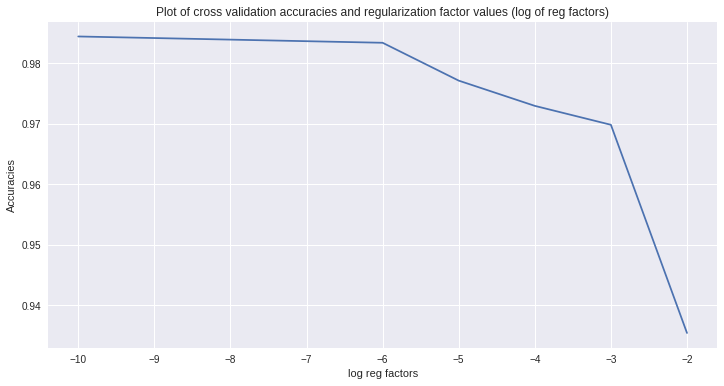

Cross Validation Results
Hyper Param values : 
[0.01, 0.001, 0.0001, 1e-05, 1e-06, 1e-10]
Cross Validation Accuracies : 
[0.9354166666666667, 0.9697916666666667, 0.9729166666666667, 0.9770833333333333, 0.9833333333333334, 0.984375]
optimal beta :  1e-10
-----------Final Train and Test-----------
epoch : 0 ------- Loss : 0.04934321119156762
epoch : 50 ------- Loss : 0.04883056653053941
epoch : 100 ------- Loss : 0.048391429224542135
epoch : 150 ------- Loss : 0.04800128633598783
------------Final Results-----------------
Test set size :  412
Num positive in test set :  184
Test Accuracy :  0.9878640776699029
Test loss :  0.04946755951904038
Confusion matrix : 
tp  :  0.4393203883495146
fn  :  0.007281553398058253
tn  :  0.5485436893203883
fp  :  0.0048543689320388345
Precision :  0.9890710382513661
Recall :  0.9836956521739131
F1 Score:  0.9863760217983651


In [6]:
#Final Training and Testing

from sklearn.model_selection import train_test_split

#Default parameter values
N_EPOCHS = 200
lr = 0.03
beta = 0.0001   # Regularization factor
n_iter_lr_decay = 80
lr_decay = 0.9
n_folds = 4
beta_list =  [0.01, 0.001, 0.0001, 0.00001, 0.000001, 1e-10]

logistic_regr = LogisticRegression(X.shape[0], X.shape[1])

X_train, X_test, y_train, y_test = train_test_split(
     X.T, y.T, test_size=0.3, random_state=0)

X_train, X_test, y_train, y_test = X_train.T, X_test.T, y_train.T, y_test.T 

print("-----------Cross Validation-----------")
hyper_params = (n_folds, N_EPOCHS, lr, beta, n_iter_lr_decay, lr_decay)
opt_beta = cross_validate(logistic_regr, X_train, y_train, hyper_params, beta_list)

print("-----------Final Train and Test-----------")
logistic_regr.fit(X_train, y_train, N_EPOCHS, lr, opt_beta, n_iter_lr_decay, lr_decay)

threshold = 0.5
y_hat, y_hat_class, loss, accuracy, confusion_dict = \
      logistic_regr.infer(X_test, y_test, threshold)

precision = confusion_dict['tp'] / (confusion_dict['tp'] + confusion_dict['fp'])
recall = confusion_dict['tp'] / (confusion_dict['tp'] + confusion_dict['fn'])
f1_score = (2*precision*recall) / (precision + recall)

print("------------Final Results-----------------")
print("Test set size : ", y_test.shape[1])
print("Num positive in test set : ", np.sum(y_test))
print("Test Accuracy : ", accuracy)
print("Test loss : ", loss)
print("Confusion matrix : ")
for key in confusion_dict.keys():
  print(key, " : ", confusion_dict[key])
print("Precision : ", precision)
print("Recall : ", recall)
print("F1 Score: ", f1_score)


